## Loading the environments

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

## Importing the packages

In [2]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph , START , END , MessageGraph 
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

import datetime
from typing import Annotated, Sequence, List, Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults 
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from IPython.display import Image, display 
from dotenv import load_dotenv
from langchain_experimental.tools import PythonREPLTool

In [3]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [4]:
tavily_search = TavilySearchResults()

python_repl = PythonREPLTool()

from langchain_core.tools import tool
@tool
def python_repl_tool(code:str):
    """Executes the provided Python code in a REPL environment. 
    To display the result of an expression or variable, use the print() function, 
    as only printed output will be shown to the user."""

    import traceback

    try:
        result = python_repl.run(code)
        success = True
    except Exception as e:
        tb = traceback.format_exc()
        return (
            f"Failed to execute the provided code.\n"
            f"Error: {e}\n"
            f"Traceback:\n{tb}"
        )
    
    output = (
        f"✅ Code executed successfully:\n"
        f"```python\n{code.strip()}\n```\n"
        f"**Output:**\n{result.strip() if result else '(No output)'}"
    )
    output += "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    return output

/var/folders/wt/k9xk77m14_scry8y3ldyfjr00000gn/T/ipykernel_61291/1810421685.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults()


In [5]:
python_repl.invoke("x = 5; print(x)")

Python REPL can execute arbitrary code. Use with caution.


'5\n'

In [6]:
from prompts import supervisor_prompt , researcher_prompt , coder_prompt , validator_prompt , enhancer_prompt , refine_prompt

## creating supervisor node

In [7]:
class Supervisor(BaseModel):
    next: Literal["enhancer", "researcher", "coder"] = Field(
        description="Determines which specialist to activate next in the workflow sequence: "
                    "'enhancer' when user input requires clarification, expansion, or refinement, "
                    "'researcher' when additional facts, context, or data collection is necessary, "
                    "'coder' when implementation, computation, or technical problem-solving is required."
    )
    reason: str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )


In [8]:
def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder"]]:
    
    supervisor_node_prompt = supervisor_prompt
    
    messages = [
        {"role": "system", "content": supervisor_node_prompt},  
    ] + state["messages"] 

    response = model.with_structured_output(Supervisor).invoke(messages)

    goto_next_node = response.next
    reason = response.reason

    print(f"--- Workflow Transition: Supervisor → {goto_next_node.upper()} ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto_next_node
    )

## creating enhancer node

In [9]:
def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:

    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
    enhancer_node_prompt = enhancer_prompt
    messages = [
        {"role": "system", "content": enhancer_node_prompt},  
    ] + state["messages"]  

    enhanced_query = model.invoke(messages)

    print(f"--- Workflow Transition: Prompt Enhancer → Supervisor ---")

    return Command(
        update={
            "messages": [  
                HumanMessage(
                    content=enhanced_query.content, 
                    name="enhancer"  
                )
            ]
        },
        goto="supervisor"
    )

## Creating researcher Node

In [10]:
def research_node(state: MessagesState) -> Command[Literal["validator"]]:

    """
        Research agent node that gathers information using Tavily search.
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """

    researcher_node_prompt = researcher_prompt
    
    research_agent = create_react_agent(
        model,  
        tools=[tavily_search],  
        prompt = researcher_node_prompt
    )

    result = research_agent.invoke(state)

    print(f"--- Workflow Transition: Researcher → Validator ---")

    return Command(
        update={
            "messages": [ 
                HumanMessage(
                    content=result["messages"][-1].content,  
                    name="researcher"  
                )
            ]
        },
        goto="validator"
    )

## Creating coder node

In [11]:
def code_node(state: MessagesState) -> Command[Literal["validator"]]:

    code_node_prompt = coder_prompt

    code_agent = create_react_agent(
        model,
        tools=[python_repl_tool],
        prompt=code_node_prompt
    )

    result = code_agent.invoke(state)

    print(f"--- Workflow Transition: Coder → Validator ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="validator"
    )

## Creating validator node

In [12]:

class Validator(BaseModel):

    next: Literal["supervisor", "FINISH"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )
    reason: str = Field(
        description="The reason for the decision."
    )

def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

    validator_node_prompt = validator_prompt

    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    messages = [
        {"role": "system", "content": validator_node_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = model.with_structured_output(Validator).invoke(messages)

    goto_next_node = response.next
    reason = response.reason

    if goto_next_node == "FINISH" or goto_next_node == END:
        goto_next_node = END  

        refine_ans_prompt = refine_prompt

        final_msg = [
        {"role": "system", "content": refine_ans_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer}]

        final_response = model.invoke(final_msg).content

        print(" --- Transitioning to END ---")  

        return Command(
            update={
                "messages": [
                    HumanMessage(content=final_response, name="validator")
                ]
            },
            goto=goto_next_node
        )
        
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")
 

        return Command(
            update={
                "messages": [
                    HumanMessage(content=reason, name="validator")
                ]
            },
            goto=goto_next_node
        )

## defining the state

In [13]:
graph = StateGraph(MessagesState)
graph.add_node("supervisor", supervisor_node) 
graph.add_node("enhancer", enhancer_node)  
graph.add_node("researcher", research_node) 
graph.add_node("coder", code_node) 
graph.add_node("validator", validator_node)  

graph.add_edge(START, "supervisor")  
app = graph.compile()

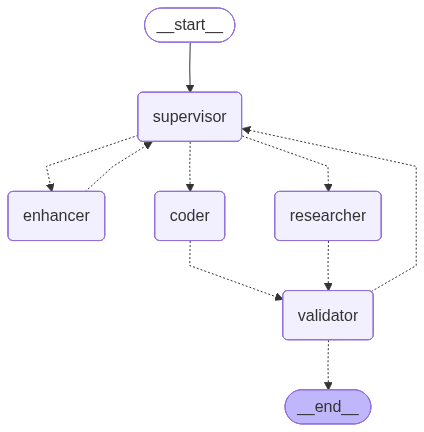

In [14]:

display(Image(app.get_graph(xray=True).draw_mermaid_png())) 

In [15]:
import pprint

inputs = {
    "messages": [
        ("user", "Weather in Chennai"),
    ]
}

for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor → RESEARCHER ---
"Output from node 'supervisor':"
HumanMessage(content='The user is requesting current weather information for Chennai, which requires up-to-date data gathering. Routing to the researcher will allow fetching the latest weather details.', additional_kwargs={}, response_metadata={}, name='supervisor', id='bca9a7b1-266c-4084-af39-897e6700a174')



/var/folders/wt/k9xk77m14_scry8y3ldyfjr00000gn/T/ipykernel_61291/3716389735.py:11: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(


--- Workflow Transition: Researcher → Validator ---
"Output from node 'researcher':"
HumanMessage(content='The current weather in Chennai shows warm temperatures with some chances of rain. Recent forecasts indicate temperatures around 28-30°C with patchy rain or light rain showers possible on several days. Humidity levels are moderate to high, and occasional thunderstorms or showers may occur.\n\nFor example, on November 8, 2025, the forecast included early showers with morning clouds and temperatures around 31°C (89°F) during the day and 26°C (78°F) at night.\n\nFor detailed and up-to-date weather information, you can check:\n- Time and Date: https://www.timeanddate.com/weather/india/chennai/ext\n- EaseWeather: https://www.easeweather.com/asia/india/tamil-nadu/chennai/november\n- Weather25: https://www.weather25.com/asia/india/tamil-nadu/chennai?page=month&month=November\n\nIf you want the very latest current weather conditions, these sources update frequently and provide hourly updat

In [16]:
result = app.invoke(inputs)
pprint.pprint(result["messages"][-1].content)

--- Workflow Transition: Supervisor → RESEARCHER ---


/var/folders/wt/k9xk77m14_scry8y3ldyfjr00000gn/T/ipykernel_61291/3716389735.py:11: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(


--- Workflow Transition: Researcher → Validator ---
 --- Transitioning to END ---
('Currently, Chennai is experiencing warm weather with temperatures around '
 '28°C (82°F). In November, the city typically sees daytime temperatures '
 'ranging from 25°C to 29°C (77°F to 84°F), with a chance of light rain or '
 'scattered showers due to the retreating monsoon season.\n'
 '\n'
 'For the most accurate and up-to-date weather forecasts, including hourly '
 'updates and rain probabilities, you can check reliable sources such as:\n'
 '- Easeweather: '
 'https://www.easeweather.com/asia/india/tamil-nadu/chennai/november\n'
 '- Weather25: '
 'https://www.weather25.com/asia/india/tamil-nadu/chennai?page=month&month=November\n'
 '\n'
 'These websites provide detailed daily forecasts to help you plan '
 'accordingly.')


In [17]:
import pprint

inputs = {
    "messages": [
        ("user", "Please retrieve the historical data for Sachin tendulkar year wise runs in odi cricket."),
    ]
}

for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor → RESEARCHER ---
"Output from node 'supervisor':"
HumanMessage(content="The user requests specific historical data about Sachin Tendulkar's year-wise ODI runs, which requires gathering accurate and detailed information from reliable sources before any further processing or presentation.", additional_kwargs={}, response_metadata={}, name='supervisor', id='66750509-42eb-4cad-8682-fe00bdc32743')



/var/folders/wt/k9xk77m14_scry8y3ldyfjr00000gn/T/ipykernel_61291/3716389735.py:11: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(


--- Workflow Transition: Researcher → Validator ---
"Output from node 'researcher':"
HumanMessage(content="Here is the year-wise ODI runs data for Sachin Tendulkar extracted from reliable cricket statistics sources (mainly ESPN Cricinfo):\n\n| Year | Matches | Innings | Not Outs | Runs | Highest Score | Batting Average | 100s | 50s | Ducks |\n|-------|---------|---------|----------|------|---------------|-----------------|------|-----|-------|\n| 1989  | 4       | 6       | 0        | 215  | 59            | 35.83           | 0    | 2   | 0     |\n| 1990  | 7       | 10      | 1        | 373  | 119           | 41.44           | 1    | 2   | 1     |\n| 1991  | 2       | 4       | 0        | 78   | 40            | 19.50           | 0    | 0   | 0     |\n| 1992  | 7       | 11      | 1        | 419  | 148           | 41.90           | 3    | 0   | 2     |\n| 1993  | 8       | 9       | 2        | 640  | 165           | 91.42           | 2    | 5   | 0     |\n| 1994  | 7       | 11      | 1

In [18]:
import pprint

inputs = {
    "messages": [
        ("user", "Give me the 20th fibonacci number"),
    ]
}
for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

--- Workflow Transition: Supervisor → CODER ---
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user's request is clear and requires a straightforward computation of the 20th Fibonacci number, so the coder agent is best suited to perform this calculation efficiently.", additional_kwargs={}, response_metadata={}, name='supervisor', id='8c4c896c-4239-4cab-8a59-1ea5d4fcf25f')]}



/var/folders/wt/k9xk77m14_scry8y3ldyfjr00000gn/T/ipykernel_61291/1552549706.py:5: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  code_agent = create_react_agent(


--- Workflow Transition: Coder → Validator ---
"Output from node 'coder':"
{ 'messages': [ HumanMessage(content='The 20th Fibonacci number is 6765.', additional_kwargs={}, response_metadata={}, name='coder', id='fc3f5283-0d2c-4a63-aa79-39d55a6d6fc7')]}

 --- Transitioning to END ---
"Output from node 'validator':"
{ 'messages': [ HumanMessage(content='The 20th Fibonacci number is 6765.', additional_kwargs={}, response_metadata={}, name='validator', id='817af9cb-d116-4a4b-ad25-befc0c66d0f7')]}

